# NLP: Yelp Review to Rating
### Authors: Tanvee Desai and Tanner Arrizabalaga

Hello! In this project, we will be looking over Yelp reviews (data available here: https://www.yelp.com/dataset) and utilizing ML/DL to accurately predict what the reviews star rating is based solely on text.

This project is split into the following parts
- Libraries
- EDA
- Data Cleaning
    - Stop word removal, HTML parsing, punctuation removal, etc.
    - Creation of a cleaned *and* stemmed dataset
- Model Implementation
    - Simple BOW Model Neural Network
    - LSTM
    - Bidirectional LSTM
    - One vs. All LSTM Approach
- Exploring Challenges
    - Challenge 5
    - Challenge 6

### Importing necessary libraries

In [1]:
# General Libraries
import json
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# NLP
import nltk
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem import PorterStemmer


# ML/DL
import tensorflow as tf
import pickle

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, BatchNormalization, SpatialDropout1D, GRU, GlobalMaxPool1D, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import utils
from keras import regularizers
from keras.models import load_model
from keras.initializers import Constant
from keras.utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [ ]:
yelp = pd.read_json("./yelp_review_training_dataset.jsonl", lines = True)
yelp.head()

How large is the data?

In [ ]:
yelp.shape

### EDA - Stars
Not too much to go off of, but let's get a general understanding of our data. How many nulls do we have?

In [ ]:
yelp.isna().sum()

In [ ]:
sns.countplot(yelp['stars'])

One thing we can potentially look at is whether or not the reviews are balanced. Let's say >=4 is positive, and <4 is negative. If we do see a significant difference in positive and negative reviews, we can balance it before training.

In [ ]:
def pos_or_neg(x):
    if x >= 4:
        return "Positive"
    else:
        return "Negative"
    
yelp['category'] = yelp['stars'].apply(pos_or_neg)

sns.countplot(yelp['category'])
num_pos = np.count_nonzero(yelp['category'] == 'Positive')
num_neg = np.count_nonzero(yelp['category'] == 'Negative')
print("Positive to negative review ratio: ", num_pos / num_neg)

There are roughly 1 and 2/3 times as many positive reviews as negative reviews. We will first try no class balancing when building the model, but may turn to class balancing later on.

### Data Cleaning - Text

In [2]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
print(STOPWORDS)

def adjust_stopwords(stopwords):
    words_to_keep = set(['nor', 'not', 'very', 'no', 'few', 'too', 'doesn', 'didn', 'wasn', 'ain', 
                        "doesn't", "isn't", "hasn't", 'shouldn', "weren't", "don't", "didn't", 
                        "shouldn't", "wouldn't", "won't", "above", "below", "haven't", "shan't", "weren"
                        "but", "wouldn", "mightn", "under", "mustn't", "over", "won", "aren", "wasn't", 
                        "than"])
    return stopwords - words_to_keep

def clean_text(text):
    new_text = BeautifulSoup(text, "lxml").text # HTML decoding
    new_text = new_text.lower() # lowercase text
    new_text = REPLACE_BY_SPACE_RE.sub(' ', new_text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    new_text = BAD_SYMBOLS_RE.sub(' ', new_text) # delete symbols which are in BAD_SYMBOLS_RE from text
   
    ps = PorterStemmer()
    
    new_text = ' '.join(ps.stem(word) for word in new_text.split()) # keeping all words, no stop word removal
    return new_text

# STOPWORDS = adjust_stopwords(STOPWORDS)
print(STOPWORDS)

{'they', 'had', 'ourselves', 'at', 'her', 'couldn', "isn't", 'too', 'herself', 'don', 'such', 'below', 'hadn', 'weren', "you're", 'your', 'been', 'll', 'y', 'ma', 'not', "you'll", 'd', 'above', 'theirs', 'again', 'no', 'over', "needn't", 'then', 'its', "hasn't", 'it', "don't", 'because', 'you', "mightn't", 'and', 'these', "it's", 'doesn', 'with', 'to', 'there', "you've", 'that', 'what', 'm', "won't", 'but', 'this', 'why', 'by', 'their', "haven't", 'be', 'other', 'against', 'where', 'does', 'mightn', 'few', 'them', "doesn't", 'can', 'between', 'isn', 'yourself', 'which', 'those', 'ain', 'as', 'up', 'will', 'some', 'was', 'into', 'himself', 't', 'who', 'on', 'o', 'is', 'of', 'hers', 'nor', 'being', "shan't", 'haven', 'are', 'whom', 'further', 'were', 'have', 'any', 'yourselves', 'i', 'very', 'wasn', 'him', 'his', 're', 'shouldn', 'or', 'our', 'if', 'each', 'the', 's', "should've", 'until', 'itself', "mustn't", 'during', 'same', 'aren', 'am', 'an', 'my', 'when', "wasn't", 'down', 'myself'

In [ ]:
# %%time
# yelp['text'] = yelp['text'].apply(clean_text)
# yelp.to_csv('cleaned_yelp_stemmed.csv')

In [3]:
text_1 = "\"Good morning, cocktails for you?\" \nWait...what? Oh...it's Vegas!\n\nDining here, you best not be dieting because this place is literally the definition of excess, but in a good way. I'm a sucker for benedicts so that was awesome. \nService was really great too and the staff was so welcoming. It was our first stop just after landing so really appreciate the service.\n\nBack in Hawaii this reminds me of Zippys or Anna Millers - that home feeling. Prices are a bit high, but for what you get it's totally worth it. Will remember this place if I ever return to Vegas in the future."
text_2 = "80 bucks, thirty minutes to fix my shattered iPhone screen. Verizon won't help you so go here"
text_3 = "Tr\u00e8s grand caf\u00e9, mais aussi calme et reposant, je m'y suis arr\u00eat\u00e9 alors que j'\u00e9tais dans le coin.\n\nOn peu y mang\u00e9 le midi, prendre une p\u00e2tisserie ou un caf\u00e9/th\u00e9. \n\nJ'ai prit un th\u00e9 qui \u00e9tait vraiment bon, et je me suis pos\u00e9 devant une des grandes baies vitr\u00e9es sur un coussin et j'ai relax\u00e9 compl\u00e8tement pendant 2 heures. \n\nMais c'est aussi une coop\u00e9rative d'artiste, avec une estrade etc.\n\nIl y a aussi un magasin Bio \u00e0 l'entr\u00e9e o\u00f9 vous retrouverez des savons, huile d'olive et plein d'autres produits."
text_4 = "Sadly, as of July 28, 2016, Silverstein bakery is permanently closed. I went there today in person and found the bad news posted on their door. :("
text_5 = "I went here  they were about to close but the cashier was especially helpful ..but I guess they were tired of work..."

clean_text(text_4)

'sadli as of juli 28 2016 silverstein bakeri is perman close i went there today in person and found the bad news post on their door'

# Model Implementation

### Evaluation
#### 1. Average Star Error (Average Absolute offset between predicted and true number of stars)
#### 2. Accuracy (Exact Match -- Number of exactly predicted star ratings / total samples)

In [2]:
from keras.losses import mean_absolute_error, binary_crossentropy, categorical_crossentropy

def my_custom_loss_ova(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    crossentropy = binary_crossentropy(y_true, y_pred)
    return mae + crossentropy

def my_custom_loss(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    crossentropy = categorical_crossentropy(y_true, y_pred)
    return mae + crossentropy

def MAE(y_true, y_pred):
    diffs = np.abs(y_true - y_pred)
    loss = np.mean(diffs)
    return loss

def Accuracy(y_true, y_pred):
    correct = y_true == y_pred
    cor_count = np.count_nonzero(correct)
    return cor_count / len(y_true)

### Train/Test Split (Unbalanced and balanced)

In [5]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')
yelp.head()

,Unnamed: 0,review_id,text,stars,category
0,0,Q1sbwvVQXV2734tPgoKj4Q,total bill for thi horribl servic over 8g thes...,1,Negative
1,1,GJXCdrto3ASJOqKeVWPi6Q,i ador travi at the hard rock s new kelli card...,5,Positive
2,2,2TzJjDVDEuAW6MR5Vuc1ug,i have to say that thi offic realli ha it toge...,5,Positive
3,3,yi0R0Ugj_xUx_Nek0-_Qig,went in for a lunch steak sandwich wa delici a...,5,Positive
4,4,11a8sVPMUFtaC7_ABRkmtw,today wa my second out of three session i had ...,1,Negative


In [4]:
X = yelp['text'].fillna('').values
y = yelp['stars']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [5]:
%%time
max_words = 3000
tokenizer = text.Tokenizer(num_words=max_words, char_level=False)

tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

encoder = LabelEncoder()
encoder.fit(y_train)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 5000)
X_test shape: (160075, 5000)
y_train shape: (373506, 5)
y_test shape: (160075, 5)
Wall time: 1min 29s


Let's save the tokenizer as well for our test submission file script.

In [7]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

### Baseline Sequential Model

Here, we are computing a single model, but in future we will optimize on several parameters, listed below
* Batch size
* Learning rate
* Gradient clipping
* Drop out
* Batch normalization
* Optimizers
* Regularization

After some tests, the main variations I noticed were from the learning rate, regularization, and the choice of the optimizer. With that being said, this baseline model will use **ADAM with a learning rate of .0001 and regularization (kernel, bias, and activity)**

In [19]:
batch_size = 256
epochs = 5

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=.0001,
#     decay_steps=10000,
#     decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.95, amsgrad=False)

baseline = Sequential()
baseline.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4),
          activity_regularizer=regularizers.l2(1e-5)))
baseline.add(BatchNormalization())
baseline.add(Activation('relu'))
baseline.add(Dropout(0.3))
baseline.add(Dense(5))
baseline.add(Activation('softmax'))

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = baseline.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/5
298804/298804 [==============================] - 88s 295us/step - loss: 1.1232 - accuracy: 0.7396 - mean_absolute_error: 0.1327 - val_loss: 0.9809 - val_accuracy: 0.7546 - val_mean_absolute_error: 0.1296
Epoch 2/5
298804/298804 [==============================] - 79s 264us/step - loss: 0.9599 - accuracy: 0.7603 - mean_absolute_error: 0.1265 - val_loss: 0.9667 - val_accuracy: 0.7541 - val_mean_absolute_error: 0.1294
Epoch 3/5
298804/298804 [==============================] - 93s 312us/step - loss: 0.9406 - accuracy: 0.7660 - mean_absolute_error: 0.1241 - val_loss: 0.9680 - val_accuracy: 0.7555 - val_mean_absolute_error: 0.1259
Epoch 4/5
298804/298804 [==============================] - 92s 307us/step - loss: 0.9307 - accuracy: 0.7716 - mean_absolute_error: 0.1220 - val_loss: 0.9776 - val_accuracy: 0.7550 - val_mean_absolute_error: 0.1279
Epoch 5/5
298804/298804 [==============================] - 84s 283us/step - loss: 0.9240 - ac

In [20]:
score = baseline.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1], "Test MAE:", score[2])

160075/160075 [==============================] - 28s 174us/step
Test accuracy: 0.7582883238792419 Test MAE: 0.12497945129871368


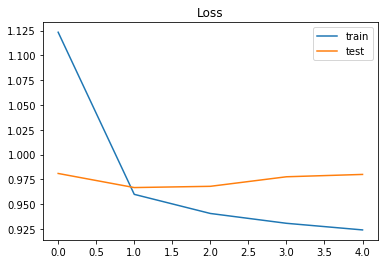

In [22]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

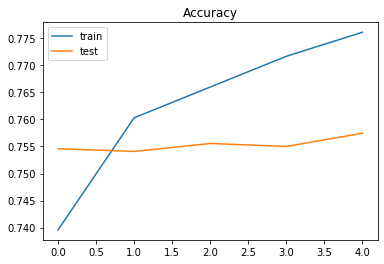

In [23]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [24]:
# Get model output
y_pred = baseline.predict(X_test)

cols = [1, 2, 3, 4, 5]

# Creating predictions table
baseline_ps = pd.DataFrame(data=y_pred, columns=cols)
y_pred_true = baseline_ps.idxmax(axis=1)

# Creating truth
baseline_truth = pd.DataFrame(data=y_test, columns=cols)
y_test_true = baseline_truth.idxmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_pred_true, y_test_true)
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,35571,5544,1716,790,1328
2,1220,2228,1141,318,140
3,507,1553,3131,1618,450
4,318,675,2735,8288,4339
5,1271,743,1540,10747,72164


In [25]:
print(classification_report(y_pred_true, y_test_true))

              precision    recall  f1-score   support

           1       0.91      0.79      0.85     44949
           2       0.21      0.44      0.28      5047
           3       0.31      0.43      0.36      7259
           4       0.38      0.51      0.43     16355
           5       0.92      0.83      0.88     86465

    accuracy                           0.76    160075
   macro avg       0.55      0.60      0.56    160075
weighted avg       0.81      0.76      0.78    160075



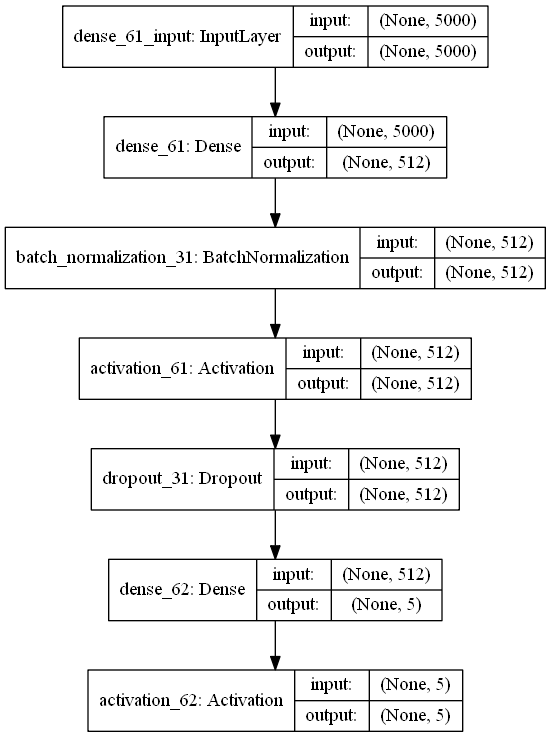

In [26]:
plot_model(baseline, to_file='baseline.png', show_shapes=True)

### Grid Search

In [16]:
def test_model(params):
    print(params)
    batch_size, epochs, learning_rate = params
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.95, amsgrad=False)

    baseline = Sequential()
    baseline.add(Dense(512, input_shape=(max_words,), kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4),
              activity_regularizer=regularizers.l2(1e-5)))
    baseline.add(BatchNormalization())
    baseline.add(Activation('relu'))
    baseline.add(Dropout(0.3))
    baseline.add(Dense(5))
    baseline.add(Activation('softmax'))
    
    baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])
    
    history = baseline.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_split=0.2)
    
    score = baseline.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score[1:])
    
    return score[1:]

In [ ]:
batch_sizes = [128, 256, 512]
epochs = [5, 10]
learning_rates = [.01, .001, .004, .008, .12]

a = [batch_sizes, epochs, learning_rates]

params = list(itertools.product(*a))

scores = {}

for p in params:
    score = test_model(p)
    scores[p] = score

Let's save this model.

In [27]:
baseline.save('./models/baseline.h5')

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### LSTM Model


#### Specific Data Prep

In [6]:
%%time
X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 5000
maxlen = 500

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

(373506,) (373506, 5)
(160075,) (160075, 5)
Wall time: 34.7 s


#### LSTM #1

In [39]:
batch_size = 256
epochs = 8

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

lstm = Sequential()
lstm.add(Embedding(max_words, 128, input_length=maxlen))
lstm.add(SpatialDropout1D(0.2))
lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
lstm.add(MaxPooling1D(pool_size=4))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(BatchNormalization())
lstm.add(Dense(50))
lstm.add(Dense(5, activation='sigmoid'))

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/8
298804/298804 [==============================] - 164s 548us/step - loss: 0.8780 - accuracy: 0.7300 - mean_absolute_error: 0.1440 - val_loss: 0.7487 - val_accuracy: 0.7606 - val_mean_absolute_error: 0.1138
Epoch 2/8
298804/298804 [==============================] - 166s 555us/step - loss: 0.7344 - accuracy: 0.7644 - mean_absolute_error: 0.1114 - val_loss: 0.7161 - val_accuracy: 0.7697 - val_mean_absolute_error: 0.1020
Epoch 3/8
298804/298804 [==============================] - 163s 545us/step - loss: 0.6968 - accuracy: 0.7753 - mean_absolute_error: 0.1066 - val_loss: 0.6897 - val_accuracy: 0.7765 - val_mean_absolute_error: 0.1060
Epoch 4/8
298804/298804 [==============================] - 165s 551us/step - loss: 0.6741 - accuracy: 0.7821 - mean_absolute_error: 0.1040 - val_loss: 0.6918 - val_accuracy: 0.7766 - val_mean_absolute_error: 0.1023
Epoch 5/8
298804/298804 [==============================] - 165s 551us/step - loss: 0.6550

#### LSTM #1: Evaluation

In [40]:
score = lstm.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1], "MAE:", score[2])

160075/160075 [==============================] - 17s 104us/step
Test accuracy: 0.7793471813201904 MAE: 0.10014468431472778


In [41]:
lstm.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 500, 128)          640000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 500, 128)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 496, 64)           41024     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 124, 64)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 128)               98816     
_________________________________________________________________
batch_normalization_47 (Batc (None, 128)               512       
_________________________________________________________________
dense_92 (Dense)             (None, 50)              

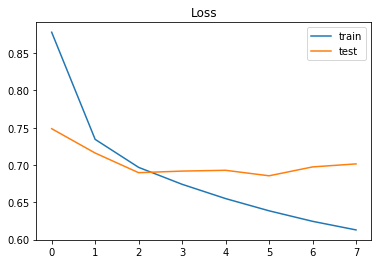

In [42]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

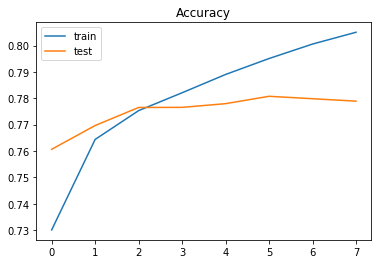

In [43]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [44]:
# Get model output
y_pred = lstm.predict(X_test)
y_pred

cols = [1, 2, 3, 4, 5]

# Creating predictions table
baseline_ps = pd.DataFrame(data=y_pred, columns=cols)
y_pred_true = baseline_ps.idxmax(axis=1)
y_pred_true

# Creating truth
baseline_truth = pd.DataFrame(data=y_test, columns=cols)
y_test_true = baseline_truth.idxmax(axis=1)
y_test_true

# Confusion matrix
cm = confusion_matrix(y_pred_true, y_test_true)
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,35122,4394,953,302,652
2,2258,3789,1549,250,106
3,369,1442,2981,838,175
4,390,767,3774,9359,3985
5,748,351,1006,11012,73503


In [45]:
print(classification_report(y_pred_true, y_test_true))

              precision    recall  f1-score   support

           1       0.90      0.85      0.87     41423
           2       0.35      0.48      0.41      7952
           3       0.29      0.51      0.37      5805
           4       0.43      0.51      0.47     18275
           5       0.94      0.85      0.89     86620

    accuracy                           0.78    160075
   macro avg       0.58      0.64      0.60    160075
weighted avg       0.82      0.78      0.80    160075



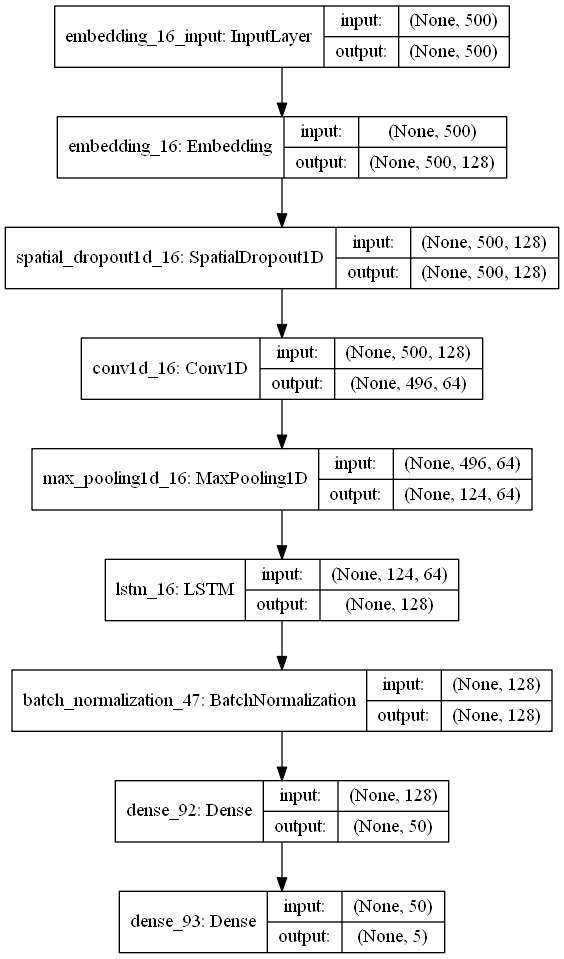

In [46]:
plot_model(lstm, to_file='lstm.png', show_shapes=True)

### GridSearch

In [30]:
def test_model(params):
    print(params)
    batch_size, epochs, learning_rate = params
    
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

    lstm = Sequential()
    lstm.add(Embedding(max_words, 128, input_length=maxlen))
    lstm.add(SpatialDropout1D(0.2))
    lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4)))
    lstm.add(MaxPooling1D(pool_size=4))
    lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    lstm.add(BatchNormalization())
    lstm.add(Dense(50))
    lstm.add(Dense(5, activation='sigmoid'))

    lstm.compile(loss=my_custom_loss,
                  optimizer=optimizer,
                  metrics=['accuracy', 'mean_absolute_error'])

    history = lstm.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)
    
    score = lstm.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
    print(score[1:])
    
    return score[1:]

In [32]:
batch_sizes = [256, 512]
epochs = [5]
learning_rates = [.0001, .00005]

a = [batch_sizes, epochs, learning_rates]

params = list(itertools.product(*a))

scores = {}

for p in params:
    score = test_model(p)
    scores[p] = score

(256, 5, 0.0001)
Train on 298804 samples, validate on 74702 samples
Epoch 1/5
298804/298804 [==============================] - 163s 547us/step - loss: 0.8879 - accuracy: 0.7259 - mean_absolute_error: 0.1469 - val_loss: 0.7423 - val_accuracy: 0.7593 - val_mean_absolute_error: 0.1081
Epoch 2/5
298804/298804 [==============================] - 165s 554us/step - loss: 0.7360 - accuracy: 0.7632 - mean_absolute_error: 0.1116 - val_loss: 0.7089 - val_accuracy: 0.7698 - val_mean_absolute_error: 0.1059
Epoch 3/5
298804/298804 [==============================] - 165s 552us/step - loss: 0.6978 - accuracy: 0.7742 - mean_absolute_error: 0.1067 - val_loss: 0.6931 - val_accuracy: 0.7752 - val_mean_absolute_error: 0.1038
Epoch 4/5
298804/298804 [==============================] - 166s 555us/step - loss: 0.6738 - accuracy: 0.7827 - mean_absolute_error: 0.1038 - val_loss: 0.6877 - val_accuracy: 0.7782 - val_mean_absolute_error: 0.1027
Epoch 5/5
160075/160075 [==============================] - 16s 102us/ste

Let's save this model as well.

In [47]:
lstm.save('./models/lstm.h5')

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### New Model

In [20]:
batch_size = 128
epochs = 3

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation='sigmoid'))

model.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/3
298804/298804 [==============================] - 2159s 7ms/step - loss: 0.9480 - accuracy: 0.7013 - mean_absolute_error: 0.1404 - val_loss: 0.7684 - val_accuracy: 0.7455 - val_mean_absolute_error: 0.1119
Epoch 2/3
298804/298804 [==============================] - 2221s 7ms/step - loss: 0.7789 - accuracy: 0.7438 - mean_absolute_error: 0.1128 - val_loss: 0.7164 - val_accuracy: 0.7619 - val_mean_absolute_error: 0.1046
Epoch 3/3
298804/298804 [==============================] - 2173s 7ms/step - loss: 0.7174 - accuracy: 0.7606 - mean_absolute_error: 0.1066 - val_loss: 0.6956 - val_accuracy: 0.7717 - val_mean_absolute_error: 0.1039


In [21]:
model.save('./models/bidirectional_lstm.h5')

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [22]:
batch_size = 128
epochs = 6

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

bidir = Sequential()
bidir.add(Embedding(max_words, 128, input_length=maxlen))
bidir.add(SpatialDropout1D(0.3))
bidir.add(Bidirectional(LSTM(128, dropout=0.3, recurrent_dropout=0.3)))
bidir.add(Dense(128, activation='relu'))
bidir.add(Dropout(0.3))
bidir.add(Dense(128, activation='relu'))
bidir.add(Dropout(0.3))
bidir.add(Dense(5, activation='sigmoid'))

bidir.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = bidir.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 298804 samples, validate on 74702 samples
Epoch 1/6
298804/298804 [==============================] - 2390s 8ms/step - loss: 0.9476 - accuracy: 0.7010 - mean_absolute_error: 0.1406 - val_loss: 0.7769 - val_accuracy: 0.7445 - val_mean_absolute_error: 0.1089
Epoch 2/6
298804/298804 [==============================] - 2197s 7ms/step - loss: 0.7789 - accuracy: 0.7437 - mean_absolute_error: 0.1128 - val_loss: 0.7195 - val_accuracy: 0.7608 - val_mean_absolute_error: 0.1076
Epoch 3/6
298804/298804 [==============================] - 2198s 7ms/step - loss: 0.7189 - accuracy: 0.7618 - mean_absolute_error: 0.1077 - val_loss: 0.6891 - val_accuracy: 0.7703 - val_mean_absolute_error: 0.1059
Epoch 4/6
298804/298804 [==============================] - 2196s 7ms/step - loss: 0.6906 - accuracy: 0.7705 - mean_absolute_error: 0.1047 - val_loss: 0.6766 - val_accuracy: 0.7728 - val_mean_absolute_error: 0.1032
Epoch 5/6
298804/298804 [==============================] - 2199s 7ms/step - loss: 0.6710 - ac

In [34]:
bidir.save('./models/bidirectional_lstm.h5')

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


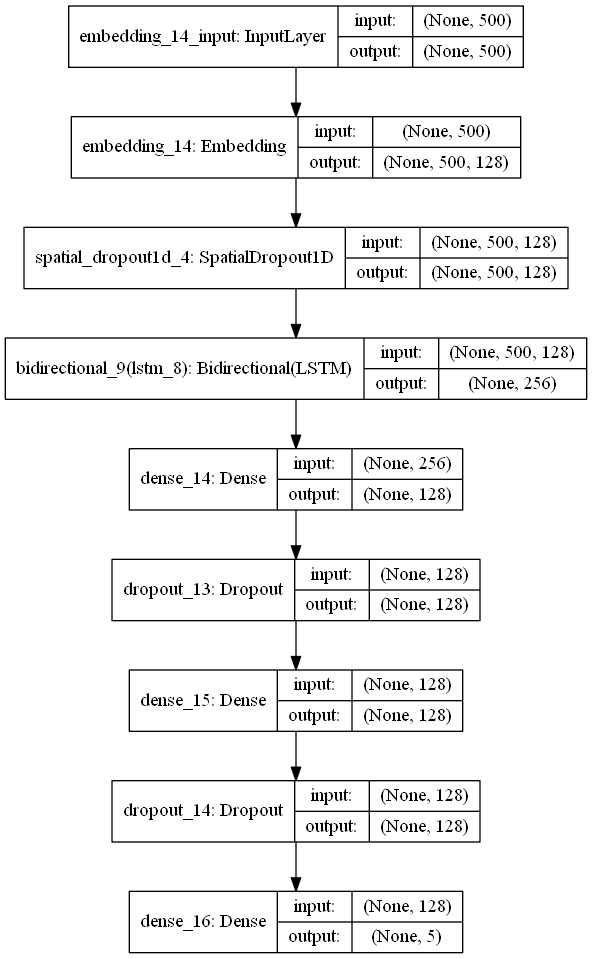

In [189]:
plot_model(bidir, to_file='bidir.png', show_shapes=True)

### One vs. All Approach
In the one vs. all approach, it goes by the following idea:
- We will have $N$ learners for the multi-class classification problem, where $N$ is the number of classes
- For each learner $L$, we will train $L$ on our training data $X_{Train}$ and $y_{Train}$. However, $y_{Train}$ consists of only one label, making it a binary classification problem instead of multinomial
    - For instance, learner $L_1$ will still use all of $X_{Train}$, but $y_{Train}$ will now be transformed to be a binary vector $v_i$ where $i$ denotes the star rating we are attempting to predict
- Once we have concluded our training, we will then create an ensemble model (bagging) that does the following
    1. $L_1$, $L_2$, ..., $L_5$ all assign $p_i$ to each record in $X_{Test}$, where $p_i$ is the likelihood observation $x_n$ belongs to class $i$
    2. From there, our prediction is the following: $P_n = argmax(p_1, p_2, p_3, p_4, p_5)$
    
After observing the challenge datasets 5 & 6, my partner and I believe this approach is a clever way to tackle the challenges while still having a strong model.

Sources: https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/one-vs-all

In [24]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# loading
# with open('tokenizer.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

max_words = 5000
maxlen = 500

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (373506, 500)
X_test shape: (160075, 500)
y_train shape: (373506, 5)
y_test shape: (160075, 5)


#### Buidling all models

In [25]:
stars = np.arange(1, 6)
models = {}
histories = {}
batch_size = 512

for star in stars:
    if star in [1, 2]:
        epochs = 2
    elif star in [3, 4]:
        epochs = 3
    else:
        epochs = 4
    
    print(star)
    y_train_sub = y_train[:, star - 1]
    
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

    sub_lstm = Sequential()
    sub_lstm.add(Embedding(max_words, 128, input_length=maxlen))
    sub_lstm.add(SpatialDropout1D(0.2))
    sub_lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
              bias_regularizer=regularizers.l2(1e-4)))
    sub_lstm.add(MaxPooling1D(pool_size=4))
    sub_lstm.add(LSTM(128))
    sub_lstm.add(BatchNormalization())
    sub_lstm.add(Dense(8))
    sub_lstm.add(Dense(1, activation='sigmoid'))
    
    sub_lstm.compile(loss=my_custom_loss_ova,
                  optimizer=optimizer,
                  metrics=['accuracy', 'mean_absolute_error'])

    history = sub_lstm.fit(X_train, y_train_sub,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_split=0.2)
    
    models[star] = sub_lstm
    histories[star] = sub_lstm

1
Train on 298804 samples, validate on 74702 samples
Epoch 1/2
298804/298804 [==============================] - 104s 346us/step - loss: 0.3599 - accuracy: 0.9114 - mean_absolute_error: 0.1185 - val_loss: 0.3723 - val_accuracy: 0.9008 - val_mean_absolute_error: 0.1120
Epoch 2/2
298804/298804 [==============================] - 97s 324us/step - loss: 0.2598 - accuracy: 0.9373 - mean_absolute_error: 0.0822 - val_loss: 0.2732 - val_accuracy: 0.9330 - val_mean_absolute_error: 0.0806
2
Train on 298804 samples, validate on 74702 samples
Epoch 1/2
298804/298804 [==============================] - 96s 322us/step - loss: 0.3540 - accuracy: 0.9255 - mean_absolute_error: 0.1154 - val_loss: 0.3435 - val_accuracy: 0.9323 - val_mean_absolute_error: 0.0749
Epoch 2/2
298804/298804 [==============================] - 96s 320us/step - loss: 0.2689 - accuracy: 0.9368 - mean_absolute_error: 0.0832 - val_loss: 0.2836 - val_accuracy: 0.9341 - val_mean_absolute_error: 0.0893
3
Train on 298804 samples, validate o

#### Building an ensemble model (maximization between learners) for all trained models
##### Testing

In [26]:
%%time
# Evaluating the models above (TEST)
y_test_und = pd.DataFrame(y_test)
y_test_true = pd.DataFrame(y_test_und.columns[np.where(y_test_und!=0)[1]]) + 1

# Unload models
lstm_1, lstm_2, lstm_3, lstm_4, lstm_5 = models[1], models[2], models[3], models[4], models[5]

## Predicting the probability for each observation each model
print("Predicting 1 star")
one_star_ps = lstm_1.predict(X_test)
print("Predicting 2 star")
two_star_ps = lstm_2.predict(X_test)
print("Predicting 3 star")
three_star_ps = lstm_3.predict(X_test)
print("Predicting 4 star")
four_star_ps = lstm_4.predict(X_test)
print("Predicting 5 star")
five_star_ps = lstm_5.predict(X_test)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["pred"] = ps.idxmax(axis=1)
ps.head()

print(MAE(ps["pred"], y_test_true[0]))
print(Accuracy(ps["pred"], y_test_true[0]))

Predicting 1 star
Predicting 2 star
Predicting 3 star
Predicting 4 star
Predicting 5 star
0.3524910198344526
0.7486178353896611
Wall time: 7min 54s


In [27]:
# Confusion matrix
cm = confusion_matrix(ps["pred"], y_test_true[0])
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,35671,5069,1331,496,554
2,1831,4336,3651,2135,546
3,86,449,2174,1224,167
4,1,3,58,535,35
5,1298,886,3049,17371,77119


In [28]:
print(classification_report(ps["pred"], y_test_true[0]))

              precision    recall  f1-score   support

           1       0.92      0.83      0.87     43121
           2       0.40      0.35      0.37     12499
           3       0.21      0.53      0.30      4100
           4       0.02      0.85      0.05       632
           5       0.98      0.77      0.87     99723

    accuracy                           0.75    160075
   macro avg       0.51      0.66      0.49    160075
weighted avg       0.90      0.75      0.81    160075



#### Saving the models


In [29]:
lstm_1.save("./models/one_star.h5")
lstm_2.save("./models/two_star.h5")
lstm_3.save("./models/three_star.h5")
lstm_4.save("./models/four_star.h5")
lstm_5.save("./models/five_star.h5")

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


### Ensemble on Test Set

In [343]:
yelp = pd.read_csv('cleaned_yelp_stemmed.csv')

X = yelp['text'].fillna('').values
y = pd.get_dummies(yelp['stars'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 5000
maxlen = 500

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle) 

print(y_test)

necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y_test.columns:
        y_test[col] = 0
        
y_test = y_test[necc_cols]
y_test = y_test.values

X_baseline = tokenizer.texts_to_matrix(X_test)
X_lstm = tokenizer.texts_to_sequences(X_test)
X_lstm = pad_sequences(X_lstm, maxlen=maxlen)

(373506,) (373506, 5)
(160075,) (160075, 5)
        1  2  3  4  5
255947  0  0  0  0  1
261035  0  0  0  0  1
355633  0  0  0  0  1
205506  0  0  0  0  1
97222   0  0  0  1  0
...    .. .. .. .. ..
491832  0  0  0  0  1
311959  0  0  0  0  1
140524  1  0  0  0  0
125037  0  0  1  0  0
200135  0  0  0  1  0

[160075 rows x 5 columns]


In [7]:
# Trying our pretrained models
# Optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.001, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)
optimizer_baseline = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# Bidirectional LSTM
bidir = load_model('./models/bidirectional_lstm.h5')

bidir.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
cols = [1, 2, 3, 4, 5]
# Baseline
print("Baseline")
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
print("LSTM")
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# Bidirectional LSTM
print("Bidirectional LSTM")
bidir_preds = pd.DataFrame(bidir.predict(X_lstm), columns=cols)
bidir_preds['bidir_pred'] = bidir_preds.idxmax(axis=1)

# One vs. all
print("OVA")
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
ova_preds = pd.DataFrame(data=data, index=cols).T

ova_preds["ova_pred"] = ova_preds.idxmax(axis=1)

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], bidir_preds['bidir_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.mode(axis=1)[0]

Baseline
LSTM
Bidirectional LSTM
OVA


In [9]:
print([MAE(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.2826112759643917, 0.7832078713103233]


In [10]:
# Confusion matrix
cm = confusion_matrix(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))
pd.DataFrame(cm, index=cols, columns=cols)

,1,2,3,4,5
1,36500,5433,1480,582,796
2,1426,3499,1866,390,118
3,170,1005,3106,1239,172
4,123,402,2735,9031,4099
5,668,404,1076,10519,73236


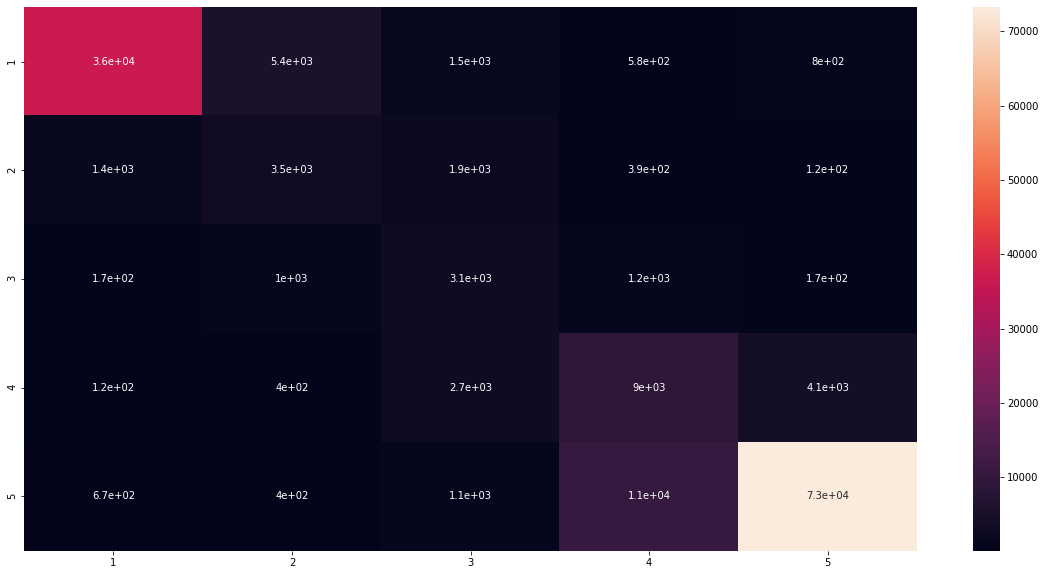

In [299]:
plt.figure(figsize = (20,10))
sns.heatmap(pd.DataFrame(cm, index=cols, columns=cols), annot=True, xticklabels=True, yticklabels=True)

In [12]:
print(classification_report(all_preds["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)))

              precision    recall  f1-score   support

         1.0       0.94      0.81      0.87     44791
         2.0       0.33      0.48      0.39      7299
         3.0       0.30      0.55      0.39      5692
         4.0       0.42      0.55      0.47     16390
         5.0       0.93      0.85      0.89     85903

    accuracy                           0.78    160075
   macro avg       0.58      0.65      0.60    160075
weighted avg       0.83      0.78      0.80    160075



From the classification report and confusion matrix above, it appears that we often mess up on the 2/3 star class, and do alright in the 4 star class. For 1 and 5 stars, we perform particularly well.

In [13]:
true_preds = all_preds.copy()
true_preds['actual_value'] = pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)
true_preds.head()

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value
0,4,5,5,5,5.0,5
1,5,5,4,2,5.0,5
2,5,5,5,5,5.0,5
3,5,5,5,5,5.0,5
4,4,4,4,5,4.0,4


In [297]:
true_preds[["baseline_pred", "lstm_pred", "ova_pred", "final_pred"]].head(105)

,baseline_pred,lstm_pred,ova_pred,final_pred
0,4,5,5,5.0
1,5,5,2,5.0
2,5,5,5,5.0
3,5,5,5,5.0
4,4,4,5,4.0
...,...,...,...,...
100,5,5,5,5.0
101,5,5,5,5.0
102,4,4,3,4.0
103,5,5,5,5.0


In [300]:
correct_preds = true_preds[true_preds['final_pred'] == true_preds['actual_value']]
n = len(X_test)

# Which model performed the best for the correct predictions?
baseline_score = np.count_nonzero(correct_preds['baseline_pred'] == correct_preds['actual_value']) / n
lstm_score = np.count_nonzero(correct_preds['lstm_pred'] == correct_preds['actual_value']) / n
bidir_score = np.count_nonzero(correct_preds['bidir_pred'] == correct_preds['actual_value']) / n
ova_score = np.count_nonzero(correct_preds['ova_pred'] == correct_preds['actual_value']) / n

print(baseline_score, lstm_score, bidir_score, ova_score)

0.7341870997969702 0.7517101358738092 0.7559643916913946 0.7116414180852725


In [14]:
incorrect_preds = true_preds[true_preds['final_pred'] != true_preds['actual_value']]

# Which model performed the best for the incorrect predictions?
baseline_score = np.count_nonzero(incorrect_preds['baseline_pred'] == incorrect_preds['actual_value']) / n
lstm_score = np.count_nonzero(incorrect_preds['lstm_pred'] == incorrect_preds['actual_value']) / n
bidir_score = np.count_nonzero(incorrect_preds['bidir_pred'] == incorrect_preds['actual_value']) / n
ova_score = np.count_nonzero(incorrect_preds['ova_pred'] == incorrect_preds['actual_value']) / n

print(baseline_score, lstm_score, bidir_score, ova_score)

incorrect_preds.head(10)

0.024094955489614243 0.027637045135092925 0.021864750898016556 0.03697641730438857


,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value
6,4,4,4,2,4.0,3
14,1,3,1,1,1.0,3
22,5,5,5,5,5.0,4
24,4,4,4,5,4.0,3
26,1,1,1,1,1.0,2
33,3,4,4,5,4.0,5
39,5,5,5,5,5.0,4
40,2,3,2,3,2.0,3
45,4,4,4,2,4.0,3
61,5,5,5,5,5.0,4


In [190]:
from collections import Counter

def detect_tie(x):
    lst = x.values
    cnt = list(Counter(lst).values())
    if len(cnt) == 2 and cnt[0] == cnt[1]:
        return True
    else:
        return False  

def vote(x):
    if not detect_tie(x):
        return x.mode()[0]
    elif set(x) == set([4, 5]):
        return x['bidir_pred']
    elif set(x) == set([1, 2]):
        return x['lstm_pred']
    elif set(x) == set([2, 3]):
        return x['lstm_pred']
    elif set(x) == set([1, 5]):
        return x['lstm_pred']
    elif set(x) == set([3, 4]):
        return x['ova_pred']
    else:
        return x.mode()[0]    

# How many ties did we have?
check = incorrect_preds.iloc[:,0:4]
ties = incorrect_preds[check.apply(detect_tie, axis=1)]
np.count_nonzero(check.apply(detect_tie, axis=1)) / n
ties.head()

print(len(ties) / len(true_preds))

0.030198344526003437


In [301]:
# Which model performed the best for ties?
baseline_score = np.count_nonzero(ties['baseline_pred'] == ties['actual_value']) / len(ties)
lstm_score = np.count_nonzero(ties['lstm_pred'] == ties['actual_value']) / len(ties)
bidir_score = np.count_nonzero(ties['bidir_pred'] == ties['actual_value']) / len(ties)
ova_score = np.count_nonzero(ties['ova_pred'] == ties['actual_value']) / len(ties)

print(baseline_score, lstm_score, bidir_score, ova_score)

0.28527099710384773 0.4555233760860571 0.2397600330988829 0.4869673148531237


In [194]:
X_test[157]

'thi locat mayb old and smaller then other but the custom servic wa amaz the ice cream wa absolutli devin and the select is way better then other locat i have been to dont wast your time by go somewher els come to thi locat and fill your sweet tooth crave'

In [303]:
# What are the most common ties?
subsets = ties[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(set, axis=1).values
Counter(frozenset(s) for s in subsets).most_common(10)

[(frozenset({4, 5}), 2356),
 (frozenset({1, 2}), 902),
 (frozenset({2, 3}), 619),
 (frozenset({1, 5}), 399),
 (frozenset({3, 4}), 365),
 (frozenset({2, 4}), 73),
 (frozenset({1, 3}), 33),
 (frozenset({3, 5}), 30),
 (frozenset({2, 5}), 29),
 (frozenset({1, 4}), 28)]

In [214]:
# For our ties, which ones perform the best?
# (4, 5)

def detect_and_return(x):
    if detect_tie(x):
        return set(x)

four_and_five_ties = true_preds[true_preds[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(detect_and_return, axis=1) == set([4,5])]

baseline_score = np.count_nonzero(four_and_five_ties['baseline_pred'] == four_and_five_ties['actual_value']) / len(four_and_five_ties)
lstm_score = np.count_nonzero(four_and_five_ties['lstm_pred'] == four_and_five_ties['actual_value']) / len(four_and_five_ties)
bidir_score = np.count_nonzero(four_and_five_ties['bidir_pred'] == four_and_five_ties['actual_value']) / len(four_and_five_ties)
ova_score = np.count_nonzero(four_and_five_ties['ova_pred'] == four_and_five_ties['actual_value']) / len(four_and_five_ties)

print(baseline_score, lstm_score, bidir_score, ova_score)
four_and_five_ties.head()

0.4231097821443827 0.4818453652285348 0.48334045279794957 0.39555745407945325


,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,custom_vote_value
29,4,5,4,5,4.0,4,4,4
64,4,5,4,5,4.0,5,5,4
66,4,5,4,5,4.0,5,4,4
67,5,4,4,5,4.0,4,3,4
73,4,4,5,5,4.0,5,4,5


In [345]:
# (1, 2)
one_and_two_ties = true_preds[true_preds[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(detect_and_return, axis=1) == set([1,2])]

baseline_score = np.count_nonzero(one_and_two_ties['baseline_pred'] == one_and_two_ties['actual_value']) / len(one_and_two_ties)
lstm_score = np.count_nonzero(one_and_two_ties['lstm_pred'] == one_and_two_ties['actual_value']) / len(one_and_two_ties)
bidir_score = np.count_nonzero(one_and_two_ties['bidir_pred'] == one_and_two_ties['actual_value']) / len(one_and_two_ties)
ova_score = np.count_nonzero(one_and_two_ties['ova_pred'] == one_and_two_ties['actual_value']) / len(one_and_two_ties)

print(baseline_score, lstm_score, bidir_score, ova_score)
one_and_two_ties.head()

0.3852785145888594 0.4363395225464191 0.40915119363395225 0.4244031830238727


,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,custom_vote_value
114,2,1,2,1,1.0,1,3,1
157,1,1,2,2,1.0,5,4,1
588,2,1,2,1,1.0,2,2,1
728,1,2,2,1,1.0,1,2,2
752,1,1,2,2,1.0,2,3,1


In [346]:
# (2, 3)
two_and_three_ties = true_preds[true_preds[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(detect_and_return, axis=1) == set([2,3])]

baseline_score = np.count_nonzero(two_and_three_ties['baseline_pred'] == two_and_three_ties['actual_value']) / len(two_and_three_ties)
lstm_score = np.count_nonzero(two_and_three_ties['lstm_pred'] == two_and_three_ties['actual_value']) / len(two_and_three_ties)
bidir_score = np.count_nonzero(two_and_three_ties['bidir_pred'] == two_and_three_ties['actual_value']) / len(two_and_three_ties)
ova_score = np.count_nonzero(two_and_three_ties['ova_pred'] == two_and_three_ties['actual_value']) / len(two_and_three_ties)

print(baseline_score, lstm_score, bidir_score, ova_score)
two_and_three_ties.head()

0.3886756238003839 0.4760076775431862 0.3982725527831094 0.418426103646833


,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,custom_vote_value
40,2,3,2,3,2.0,3,3,3
253,2,3,3,2,2.0,3,2,3
272,3,3,2,2,2.0,3,4,3
418,2,3,3,2,2.0,2,3,3
594,3,3,2,2,2.0,3,3,3


In [302]:
# (1, 5)
one_and_five_ties = true_preds[true_preds[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(detect_and_return, axis=1) == set([1,5])]

baseline_score = np.count_nonzero(one_and_five_ties['baseline_pred'] == one_and_five_ties['actual_value']) / len(one_and_five_ties)
lstm_score = np.count_nonzero(one_and_five_ties['lstm_pred'] == one_and_five_ties['actual_value']) / len(one_and_five_ties)
bidir_score = np.count_nonzero(one_and_five_ties['bidir_pred'] == one_and_five_ties['actual_value']) / len(one_and_five_ties)
ova_score = np.count_nonzero(one_and_five_ties['ova_pred'] == one_and_five_ties['actual_value']) / len(one_and_five_ties)

print(baseline_score, lstm_score, bidir_score, ova_score)
one_and_five_ties.head()

0.34146341463414637 0.3902439024390244 0.38880918220946914 0.36585365853658536


,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,custom_vote_value
221,5,5,1,1,1.0,1,3,1
521,1,5,1,5,1.0,1,4,1
1156,1,5,1,5,1.0,1,5,1
1496,1,5,1,5,1.0,5,4,1
1861,5,1,1,5,1.0,5,4,1


In [305]:
# (3, 4)
three_and_four_ties = true_preds[true_preds[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(detect_and_return, axis=1) == set([3,4])]

baseline_score = np.count_nonzero(three_and_four_ties['baseline_pred'] == three_and_four_ties['actual_value']) / len(three_and_four_ties)
lstm_score = np.count_nonzero(three_and_four_ties['lstm_pred'] == three_and_four_ties['actual_value']) / len(three_and_four_ties)
bidir_score = np.count_nonzero(three_and_four_ties['bidir_pred'] == three_and_four_ties['actual_value']) / len(three_and_four_ties)
ova_score = np.count_nonzero(three_and_four_ties['ova_pred'] == three_and_four_ties['actual_value']) / len(three_and_four_ties)

print(baseline_score, lstm_score, bidir_score, ova_score)
three_and_four_ties.head()

0.4449275362318841 0.45362318840579713 0.47246376811594204 0.4753623188405797


,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,custom_vote_value
217,3,4,4,3,3.0,3,4,3
384,3,4,4,3,3.0,4,4,3
438,3,4,4,3,3.0,3,4,3
613,4,4,3,3,3.0,4,4,3
721,3,4,4,3,3.0,3,3,3


In [306]:
# What happens if we create a tiebreaker function?
def vote(x):
    if not detect_tie(x):
        return x.mode()[0]
    elif set(x) == set([4, 5]):
        return x['bidir_pred']
    elif set(x) == set([1, 2]):
        return x['lstm_pred']
    elif set(x) == set([2, 3]):
        return x['lstm_pred']
    elif set(x) == set([1, 5]):
        return x['bidir_pred']
    elif set(x) == set([3, 4]):
        return x['ova_pred']
    else:
        return x.mode()[0]
        
        
true_preds['custom_vote_value'] = true_preds[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred']].apply(vote, axis=1)

In [307]:
true_preds.iloc[ties.index]

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,custom_vote_value
40,2,3,2,3,2.0,3,3,3
64,4,5,4,5,4.0,5,5,4
66,4,5,4,5,4.0,5,4,4
73,4,4,5,5,4.0,5,4,5
136,5,4,4,5,4.0,5,3,4
...,...,...,...,...,...,...,...,...
159965,5,4,4,5,4.0,5,4,4
159987,5,4,4,5,4.0,5,5,4
160047,4,5,4,5,4.0,5,4,4
160067,3,2,3,2,2.0,3,3,2


In [308]:
print([MAE(true_preds["custom_vote_value"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(true_preds["custom_vote_value"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.2817304388567859, 0.7834452600343589]


### Boosted LSTM

In [17]:
incorrect_text = pd.DataFrame(X_test, columns=['text'])
incorrect_text.iloc[incorrect_preds.index]

,text
6,the food in thi restaur is excel the onli thin...
14,terribl technic and custom servic i download a...
22,eric did a great job captur 4 kid under 8 not ...
24,gould staf locat in north scottsdal off the 10...
26,tri the 18 burger and 10 beer tax includ befor...
...,...
160063,i m go to give thi an ok caus i dont know what...
160067,kind of underwhelm went with my wife after din...
160068,love their cold brew ad sf cinnamon dolc syrup...
160073,veri friendli and effici i call the day befor ...


In [18]:
X_test_boosted = incorrect_text.iloc[incorrect_preds.index, 0]
X_test_boosted

6         the food in thi restaur is excel the onli thin...
14        terribl technic and custom servic i download a...
22        eric did a great job captur 4 kid under 8 not ...
24        gould staf locat in north scottsdal off the 10...
26        tri the 18 burger and 10 beer tax includ befor...
                                ...                        
160063    i m go to give thi an ok caus i dont know what...
160067    kind of underwhelm went with my wife after din...
160068    love their cold brew ad sf cinnamon dolc syrup...
160073    veri friendli and effici i call the day befor ...
160074    if your in the area or are go to be in the are...
Name: text, Length: 34703, dtype: object

In [19]:
incorrect_labels = pd.DataFrame(y_test).iloc[incorrect_preds.index]
incorrect_labels

,0,1,2,3,4
6,0,0,1,0,0
14,0,0,1,0,0
22,0,0,0,1,0
24,0,0,1,0,0
26,0,1,0,0,0
...,...,...,...,...,...
160063,0,0,1,0,0
160067,0,0,1,0,0
160068,0,0,0,0,1
160073,0,0,1,0,0


In [20]:
y_test_boosted = incorrect_labels.values
y_test_boosted

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]], dtype=uint8)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_test_boosted, y_test_boosted, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

max_words = 5000
maxlen = 500

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# For the LSTM, we are going to pad our sequences
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

(27762,) (27762, 5)
(6941,) (6941, 5)


In [23]:
batch_size = 128
epochs = 4

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=.001,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

boosted_lstm = Sequential()
boosted_lstm.add(Embedding(max_words, 128, input_length=maxlen))
boosted_lstm.add(SpatialDropout1D(0.2))
boosted_lstm.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
          bias_regularizer=regularizers.l2(1e-4)))
boosted_lstm.add(MaxPooling1D(pool_size=4))
boosted_lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
boosted_lstm.add(BatchNormalization())
boosted_lstm.add(Dense(50))
boosted_lstm.add(Dense(5, activation='sigmoid'))

boosted_lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

history = boosted_lstm.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

Train on 22209 samples, validate on 5553 samples
Epoch 1/4
22209/22209 [==============================] - 35s 2ms/step - loss: 1.7338 - accuracy: 0.4295 - mean_absolute_error: 0.3349 - val_loss: 1.7217 - val_accuracy: 0.3675 - val_mean_absolute_error: 0.2362
Epoch 2/4
22209/22209 [==============================] - 30s 1ms/step - loss: 1.3866 - accuracy: 0.5291 - mean_absolute_error: 0.1986 - val_loss: 1.5986 - val_accuracy: 0.3920 - val_mean_absolute_error: 0.2091
Epoch 3/4
22209/22209 [==============================] - 22s 996us/step - loss: 1.2408 - accuracy: 0.5879 - mean_absolute_error: 0.1857 - val_loss: 1.5287 - val_accuracy: 0.4421 - val_mean_absolute_error: 0.2038
Epoch 4/4
22209/22209 [==============================] - 23s 1ms/step - loss: 1.0664 - accuracy: 0.6661 - mean_absolute_error: 0.1720 - val_loss: 1.5888 - val_accuracy: 0.4497 - val_mean_absolute_error: 0.1989


In [43]:
boosted_lstm.save("./models/boosted_lstm.h5")

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [24]:
print("Boosted LSTM")
boosted_preds = pd.DataFrame(boosted_lstm.predict(X_lstm), columns=cols)
boosted_preds['boosted_pred'] = boosted_preds.idxmax(axis=1)
boosted_preds

Boosted LSTM


,1,2,3,4,5,boosted_pred
0,0.000231,0.000306,0.018174,0.554212,0.048433,4
1,0.006634,0.004356,0.043176,0.099527,0.012136,4
2,0.002725,0.002462,0.021757,0.530631,0.034182,4
3,0.000248,0.000885,0.025921,0.721028,0.034878,4
4,0.003396,0.002742,0.040774,0.209530,0.050454,4
...,...,...,...,...,...,...
160070,0.000626,0.000840,0.011876,0.697889,0.013636,4
160071,0.000340,0.000090,0.030107,0.961066,0.001054,4
160072,0.013922,0.402921,0.143478,0.005673,0.000570,2
160073,0.002068,0.002220,0.027922,0.154341,0.049029,4


In [344]:
boosted_lstm.evaluate(X_lstm, y_test)

160075/160075 [==============================] - 109s 679us/step


[2.707010384560674, 0.1980009377002716, 0.252422571182251]

### New Ensemble with Boosted Model

In [26]:
true_preds['boosted_pred'] = boosted_preds['boosted_pred']
true_preds.head()

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred
0,4,5,5,5,5.0,5,4
1,5,5,4,2,5.0,5,4
2,5,5,5,5,5.0,5,4
3,5,5,5,5,5.0,5,4
4,4,4,4,5,4.0,4,4


In [27]:
true_preds_with_boosted = true_preds.copy()

In [32]:
true_preds_with_boosted['final_pred'] = true_preds_with_boosted[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred', 'boosted_pred']].mode(axis=1)[0]
true_preds_with_boosted.head()

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred
0,4,5,5,5,5.0,5,4
1,5,5,4,2,4.0,5,4
2,5,5,5,5,5.0,5,4
3,5,5,5,5,5.0,5,4
4,4,4,4,5,4.0,4,4


In [35]:
print([MAE(true_preds_with_boosted["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(true_preds_with_boosted["final_pred"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.26952990785569264, 0.7906168983289084]


### What happens if we give it two votes?

In [37]:
true_preds_with_boosted['final_pred_two_votes'] = true_preds_with_boosted[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred', 'boosted_pred', 'boosted_pred']].mode(axis=1)[0]
true_preds_with_boosted.head()

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,final_pred_two_votes
0,4,5,5,5,5.0,5,4,4.0
1,5,5,4,2,4.0,5,4,4.0
2,5,5,5,5,5.0,5,4,5.0
3,5,5,5,5,5.0,5,4,5.0
4,4,4,4,5,4.0,4,4,4.0


In [38]:
print([MAE(true_preds_with_boosted["final_pred_two_votes"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(true_preds_with_boosted["final_pred_two_votes"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.26676245509917224, 0.7895923785725442]


### What happens if we give our best performing model two votes?
##### In this case, the One vs. All model performed pretty well

In [118]:
true_preds_with_boosted['final_pred_two_votes_ova'] = true_preds_with_boosted[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred', 'boosted_pred', 'ova_pred']].mode(axis=1)[0]
true_preds_with_boosted.head()

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,final_pred_two_votes,final_pred_two_votes_ova
0,4,5,5,5,5.0,5,4,4.0,5.0
1,5,5,4,2,4.0,5,4,4.0,2.0
2,5,5,5,5,5.0,5,4,5.0,5.0
3,5,5,5,5,5.0,5,4,5.0,5.0
4,4,4,4,5,4.0,4,4,4.0,4.0


In [119]:
print([MAE(true_preds_with_boosted["final_pred_two_votes_ova"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(true_preds_with_boosted["final_pred_two_votes_ova"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.28724035608308607, 0.7841199437763549]


### What happens if we give the second best performing model two votes?
##### In this case, the LSTM was second

In [121]:
true_preds_with_boosted['final_pred_two_votes_lstm'] = true_preds_with_boosted[['baseline_pred', 'lstm_pred', 'bidir_pred', 'ova_pred', 'boosted_pred', 'lstm_pred']].mode(axis=1)[0]
true_preds_with_boosted.head()

,baseline_pred,lstm_pred,bidir_pred,ova_pred,final_pred,actual_value,boosted_pred,final_pred_two_votes,final_pred_two_votes_ova,final_pred_two_votes_lstm
0,4,5,5,5,5.0,5,4,4.0,5.0,5.0
1,5,5,4,2,4.0,5,4,4.0,2.0,5.0
2,5,5,5,5,5.0,5,4,5.0,5.0,5.0
3,5,5,5,5,5.0,5,4,5.0,5.0,5.0
4,4,4,4,5,4.0,4,4,4.0,4.0,4.0


In [122]:
print([MAE(true_preds_with_boosted["final_pred_two_votes_lstm"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1)), Accuracy(true_preds_with_boosted["final_pred_two_votes_lstm"], pd.DataFrame(data=y_test, columns=cols).idxmax(axis=1))])

[0.27154146493831016, 0.7873371856942059]



# Challenges
### Challenge 5

In [9]:
c5 = pd.read_json("./yelp_challenge_5_with_answers.jsonl", lines = True)
print(c5.shape)
c5.head()

(500, 3)


,review_id,text,stars
0,50,I went to this campus for 1 semester. I was in...,2
1,51,I have rated it a two star based on its compar...,2
2,52,"Just like most of the reviews, we ordered and ...",2
3,53,I only go here if it is an emergency. I HATE i...,2
4,54,Rude staff. I got 60 feeder fish and about 15 ...,2


##### Quick EDA

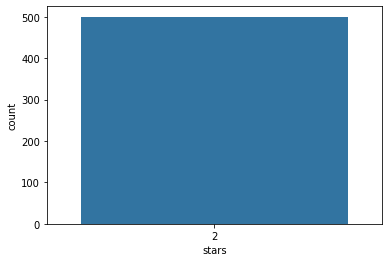

In [310]:
sns.countplot(c5['stars'])

##### Pre-processing

In [311]:
c5['text'] = c5['text'].apply(clean_text)
c5.head()

,review_id,text,stars
0,50,i went to thi campu for 1 semest i wa in busi ...,2
1,51,i have rate it a two star base on it compariso...,2
2,52,just like most of the review we order and paid...,2
3,53,i onli go here if it is an emerg i hate it tha...,2
4,54,rude staff i got 60 feeder fish and about 15 w...,2


##### Load previous tokenizer

In [312]:
X = c5['text'].fillna('').values
y = pd.get_dummies(c5['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)   
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=500)

##### Load and compile models

In [313]:
# Trying our pretrained models
# Optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.001, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)
optimizer_baseline = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# Bidirectional LSTM
bidir = load_model('./models/bidirectional_lstm.h5')

bidir.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# # Boosted LSTM
# boosted_lstm = load_model('./models/boosted_lstm.h5')

# boosted_lstm.compile(loss=my_custom_loss,
#               optimizer=optimizer,
#               metrics=['accuracy', 'mean_absolute_error'])

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##### Evaluate Models

In [314]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# Bidirectional LSTM
print(bidir.evaluate(X_lstm, y))

# # Boosted LSTM
# print(boosted_lstm.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 318us/step
[2.354674012184143, 0.23199999332427979, 0.2999608814716339]
500/500 [==============================] - 0s 950us/step
[1.906020104408264, 0.3440000116825104, 0.24954305589199066]
500/500 [==============================] - 3s 5ms/step
[1.8080296010971069, 0.30000001192092896, 0.25405579805374146]
[0.752, 0.416]


##### Attempt Ensemble

In [315]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# Bidirectional LSTM
bidir_preds = pd.DataFrame(bidir.predict(X_lstm), columns=cols)
bidir_preds['bidir_pred'] = bidir_preds.idxmax(axis=1)

# # Boosted LSTM
# boosted_preds = pd.DataFrame(boosted_lstm.predict(X_lstm), columns=cols)
# boosted_preds['boosted_pred'] = boosted_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], bidir_preds['bidir_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.apply(vote, axis=1)

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.794, 0.336]


##### Misc.

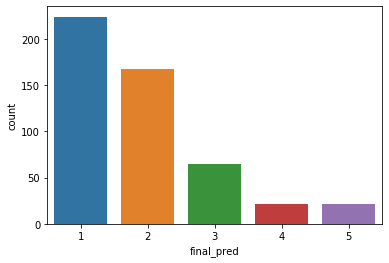

In [316]:
sns.countplot(all_preds["final_pred"])

### Challenge 6

In [5]:
c6 = pd.read_json("./yelp_challenge_6_with_answers.jsonl", lines = True)
print(c6.shape)
c6.head()

(500, 3)


,review_id,text,stars
0,60,Amazing for Trees\n\n$20 for a 5 gallon . I wi...,5
1,61,How the hell can Taco Bell be closed before mi...,5
2,62,I actually had no intention of visiting this p...,5
3,63,Yesterday around 3:30 pm I was driving west on...,5
4,64,DR FITZMAURICE did surgery on both hands on th...,5


##### Quick EDA

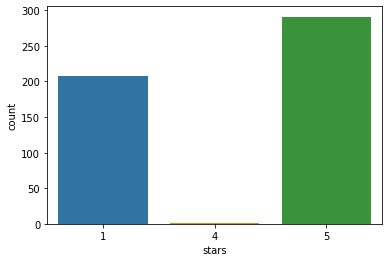

In [318]:
sns.countplot(c6['stars'])

##### Pre-processing

In [319]:
c6['text'] = c6['text'].apply(clean_text)
c6.head()

,review_id,text,stars
0,60,amaz for tree 20 for a 5 gallon i will never g...,5
1,61,how the hell can taco bell be close befor midn...,5
2,62,i actual had no intent of visit thi place at a...,5
3,63,yesterday around 3 30 pm i wa drive west on pi...,5
4,64,dr fitzmauric did surgeri on both hand on the ...,5


##### Load previous tokenizer

In [320]:
X = c6['text'].fillna('').values
y = pd.get_dummies(c6['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=500)

##### Load and compile models

In [321]:
# Trying our pretrained models
# Optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.001, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)
optimizer_baseline = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# Bidirectional LSTM
bidir = load_model('./models/bidirectional_lstm.h5')

bidir.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##### Evaluate Models

In [322]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# Bidirectional LSTM
print(bidir.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 244us/step
[2.583513156890869, 0.4740000069141388, 0.24528849124908447]
500/500 [==============================] - 1s 1ms/step
[2.7549539794921873, 0.41200000047683716, 0.22898471355438232]
500/500 [==============================] - 2s 5ms/step
[2.7555558910369875, 0.41600000858306885, 0.23118716478347778]
[2.084, 0.456]


##### Attempt Ensemble

In [323]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# Bidirectional LSTM
bidir_preds = pd.DataFrame(bidir.predict(X_lstm), columns=cols)
bidir_preds['bidir_pred'] = bidir_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], bidir_preds['bidir_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.apply(vote, axis=1)

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[2.08, 0.442]


##### Misc.

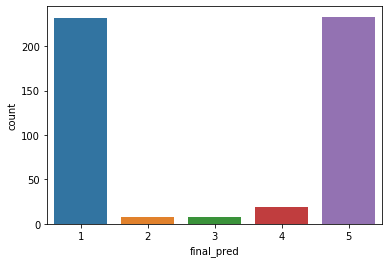

In [324]:
sns.countplot(all_preds["final_pred"])

### Challenge 3

In [325]:
c3 = pd.read_json("./yelp_challenge_3_with_answers.jsonl", lines = True)
print(c3.shape)
c3.head()

(534, 3)


,review_id,text,stars
0,30,We stopped here for lunch today and were pleas...,4
1,31,We went for a quick lunch here - it's all reas...,3
2,32,"Very bad food, avoid it. We were a group of 4 ...",2
3,33,Bring a friend or two to help open the door. I...,3
4,34,Ukai serves some of the best sushi and sashimi...,4


##### Quick EDA

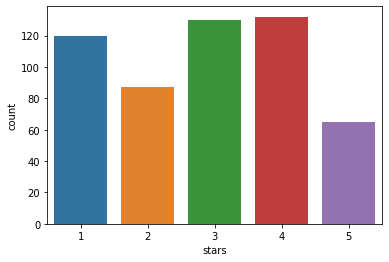

In [326]:
sns.countplot(c3['stars'])

##### Pre-processing

In [327]:
c3['text'] = c3['text'].apply(clean_text)
c3.head()

,review_id,text,stars
0,30,we stop here for lunch today and were pleasant...,4
1,31,we went for a quick lunch here it s all reason...,3
2,32,veri bad food avoid it we were a group of 4 an...,2
3,33,bring a friend or two to help open the door i ...,3
4,34,ukai serv some of the best sushi and sashimi i...,4


##### Load previous tokenizer

In [328]:
X = c3['text'].fillna('').values
y = pd.get_dummies(c3['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)  
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=500)

##### Load and compile models

In [329]:
# Trying our pretrained models
# Optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.001, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)
optimizer_baseline = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# Bidirectional LSTM
bidir = load_model('./models/bidirectional_lstm.h5')

bidir.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##### Evaluate Models

In [330]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# Bidirectional LSTM
print(bidir.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

534/534 [==============================] - 0s 232us/step
[1.3791420419564409, 0.5805243253707886, 0.20395886898040771]
534/534 [==============================] - 0s 905us/step
[1.163563758692938, 0.584269642829895, 0.18014183640480042]
534/534 [==============================] - 3s 5ms/step
[1.0715686533781472, 0.617977499961853, 0.17923445999622345]
[0.6629213483146067, 0.46629213483146065]


##### Attempt Ensemble

In [331]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# Bidirectional LSTM
bidir_preds = pd.DataFrame(bidir.predict(X_lstm), columns=cols)
bidir_preds['bidir_pred'] = bidir_preds.idxmax(axis=1)

# Boosted LSTM
boosted_preds = pd.DataFrame(boosted_lstm.predict(X_lstm), columns=cols)
boosted_preds['boosted_pred'] = boosted_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], bidir_preds['bidir_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.apply(vote, axis=1)

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.4400749063670412, 0.6142322097378277]


##### Misc.

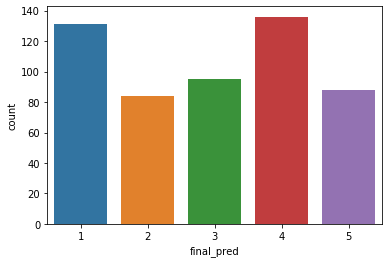

In [332]:
sns.countplot(all_preds["final_pred"])

### Challenge 8

In [333]:
c8 = pd.read_json("./yelp_challenge_8_with_answers.jsonl", lines = True)
print(c8.shape)
c8.head()

(500, 3)


,review_id,text,stars
0,qOOv-A-vo3kMT0yi4jIIlg,Not bad for fast food.,4
1,uqxkO6B6w_sIDSAGr0k_0A,Une institution du café,4
2,0o_gGSU0m_4QyNLWEHKgug,J ai vraiment aimé !!!!,4
3,BKAj-fKWW5G3yt3xAkbUCQ,They have good poutine.,4
4,fAhp8IwuGNT0ywKmsCs6VQ,Very old and dirty vans.,1


##### Quick EDA

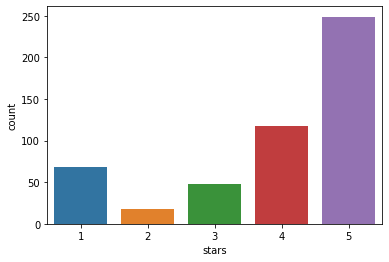

In [334]:
sns.countplot(c8['stars'])

##### Pre-processing

In [335]:
c8['text'] = c8['text'].apply(clean_text)
c8.head()

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\bs4\__init__.py:398: UserWarning: "https://casetext.com/case/united-states-v-butterbaugh-2" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  markup


,review_id,text,stars
0,qOOv-A-vo3kMT0yi4jIIlg,not bad for fast food,4
1,uqxkO6B6w_sIDSAGr0k_0A,une institut du caf,4
2,0o_gGSU0m_4QyNLWEHKgug,j ai vraiment aim,4
3,BKAj-fKWW5G3yt3xAkbUCQ,they have good poutin,4
4,fAhp8IwuGNT0ywKmsCs6VQ,veri old and dirti van,1


##### Load previous tokenizer

In [336]:
X = c8['text'].fillna('').values
y = pd.get_dummies(c8['stars'])

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
necc_cols = [1, 2, 3, 4, 5]
for col in necc_cols:
    if col not in y.columns:
        y[col] = 0
        
y = y[necc_cols]
y = y.values

X_baseline = tokenizer.texts_to_matrix(X)
X_lstm = tokenizer.texts_to_sequences(X)
X_lstm = pad_sequences(X_lstm, maxlen=500)

##### Load and compile models

In [337]:
# Trying our pretrained models
# Optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=.001, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)
optimizer_baseline = keras.optimizers.Adam(learning_rate=.0007, beta_1=0.9, beta_2=0.99, amsgrad=False, clipvalue=.3)

# Baseline
baseline = load_model('./models/baseline.h5')

baseline.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# LSTM
lstm = load_model('./models/lstm.h5')

lstm.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# Bidirectional LSTM
bidir = load_model('./models/bidirectional_lstm.h5')

bidir.compile(loss=my_custom_loss,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

# One vs. all
lstm_1 = load_model('./models/one_star.h5')

lstm_1.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_2 = load_model('./models/two_star.h5')

lstm_2.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_3 = load_model('./models/three_star.h5')

lstm_3.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_4 = load_model('./models/four_star.h5')

lstm_4.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

lstm_5 = load_model('./models/five_star.h5')

lstm_5.compile(loss=my_custom_loss_ova,
              optimizer=optimizer,
              metrics=['accuracy', 'mean_absolute_error'])

C:\Users\Tanner\Anaconda3\envs\yelp\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


##### Evaluate Models

In [338]:
# Baseline
print(baseline.evaluate(X_baseline, y))

# LSTM
print(lstm.evaluate(X_lstm, y))

# Bidirectional LSTM
print(bidir.evaluate(X_lstm, y))

# One vs. All
one_star_ps = lstm_1.predict(X_lstm)
two_star_ps = lstm_2.predict(X_lstm)
three_star_ps = lstm_3.predict(X_lstm)
four_star_ps = lstm_4.predict(X_lstm)
five_star_ps = lstm_5.predict(X_lstm)

data = [one_star_ps.flatten(), two_star_ps.flatten(), three_star_ps.flatten(), four_star_ps.flatten(), five_star_ps.flatten()]
cols = [1, 2, 3, 4, 5]
ps = pd.DataFrame(data=data, index=cols).T

ps["ova_pred"] = ps.idxmax(axis=1)

print([MAE(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(ps["ova_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

500/500 [==============================] - 0s 274us/step
[1.2652510585784913, 0.6240000128746033, 0.18434946238994598]
500/500 [==============================] - 0s 984us/step
[1.0746466426849366, 0.6340000033378601, 0.15916605293750763]
500/500 [==============================] - 2s 5ms/step
[1.0040428504943848, 0.6359999775886536, 0.14881528913974762]
[0.6, 0.61]


##### Attempt Ensemble

In [339]:
# Baseline
baseline_preds = pd.DataFrame(baseline.predict(X_baseline), columns=cols)
baseline_preds['baseline_pred'] = baseline_preds.idxmax(axis=1)

# LSTM
lstm_preds = pd.DataFrame(lstm.predict(X_lstm), columns=cols)
lstm_preds['lstm_pred'] = lstm_preds.idxmax(axis=1)

# Bidirectional LSTM
bidir_preds = pd.DataFrame(bidir.predict(X_lstm), columns=cols)
bidir_preds['bidir_pred'] = bidir_preds.idxmax(axis=1)

# One vs. all
ova_preds = ps

all_preds = pd.DataFrame([baseline_preds['baseline_pred'], lstm_preds['lstm_pred'], bidir_preds['bidir_pred'], ova_preds['ova_pred']]).T
all_preds["final_pred"] = all_preds.apply(vote, axis=1)

print([MAE(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1)), Accuracy(all_preds["final_pred"], pd.DataFrame(data=y, columns=cols).idxmax(axis=1))])

[0.504, 0.638]


##### Misc.

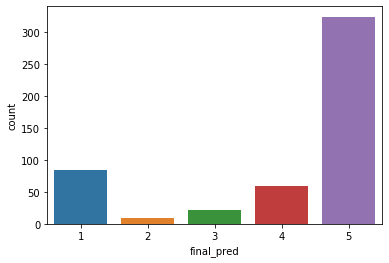

In [340]:
sns.countplot(all_preds["final_pred"])